## Library

In [1]:
import os
import glob
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_percentage_error

import multiprocessing

import warnings
warnings.simplefilter("ignore")

from tqdm.auto import tqdm
import optuna
import unicodedata

import lightgbm as lgb

## CFG

In [2]:
class CFG:
    seed = 42
    n_splits = 5
    data_dir = "data/"

## Utils

$$
\text{MAPE}(y, \hat{y}) = \frac{100\%}{N} \sum_{i=1}^{N} \frac{|y_i - \hat{y}_i|}{y_i}
$$

In [3]:
def get_score(y_true, y_pred):
    """get MAPE score"""
    score = mean_absolute_percentage_error(y_true, y_pred)
    return score * 100

get_score(y_true=[2], y_pred=[4]), get_score(y_true=[10000], y_pred=[10002]), get_score(y_true=[10000], y_pred=[20000]), 

(100.0, 0.02, 100.0)

式と簡単な実験より、$|y_i - \hat{y}_i|$の値が同じでもy_trueが小さいほどMAPEが大きくなりやすいことが分かる

## Data Loading

In [4]:
train = pd.read_csv(CFG.data_dir+"train.csv")
test = pd.read_csv(CFG.data_dir+"test.csv")

## Cross Validation

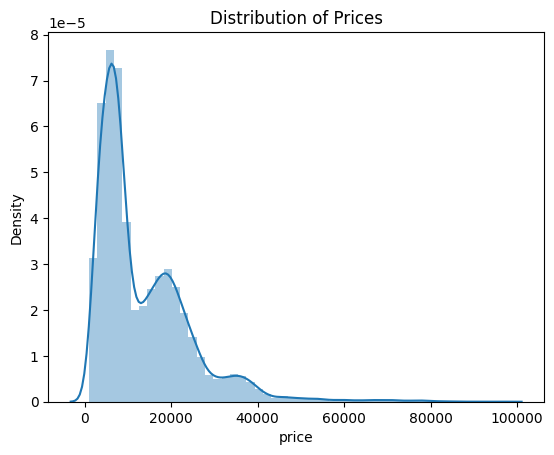

In [5]:
sns.distplot(train["price"])
plt.title("Distribution of Prices")
plt.show()

"Distribution of Prices"が多峰性を持っている。  
-> 3つくらいの性質が混ざっている？

In [6]:
# simpleなKFold
train.sort_values(by="id", ignore_index=True, inplace=True)
kf = KFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
for i, (_, val) in enumerate(kf.split(X=train)):
    train.loc[val, "fold"] = i
print("The variance of the mean of the folds: ", train.groupby("fold")["price"].mean().std())

The variance of the mean of the folds:  226.3739393323663


In [7]:
# priceを層にしてStratifiedKFold    (https://neptune.ai/blog/cross-validation-mistakes)
train.sort_values(by="id", ignore_index=True, inplace=True)
train["price_map"] = pd.cut(train["price"], bins=20, labels=False)

skf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
for i, (_, val) in enumerate(skf.split(X=train, y=train["price_map"])):
    train.loc[val, "fold"] = i
print("The variance of the mean of the folds: ", train.groupby("fold")["price"].mean().std())

The variance of the mean of the folds:  8.784566908616718


In [10]:
# priceを小さい順に各foldに振り分ける
train.sort_values(by="price", ignore_index=True, inplace=True)
train["fold"] = [col for col in range(CFG.n_splits)] * (train.shape[0]//CFG.n_splits) \
                + [col for col in range(0, train.shape[0] - len([col for col in range(CFG.n_splits)] * (train.shape[0] //CFG.n_splits)))]
display(train["fold"].head(10))
display(train["fold"].tail(10))
train.sort_values(by="id", ignore_index=True, inplace=True)
print("The variance of the mean of the folds: ", train.groupby("fold")["price"].mean().std())

0    0
1    1
2    2
3    3
4    4
5    0
6    1
7    2
8    3
9    4
Name: fold, dtype: int64

27522    2
27523    3
27524    4
27525    0
27526    1
27527    2
27528    3
27529    4
27530    0
27531    1
Name: fold, dtype: int64

The variance of the mean of the folds:  4.695908800203918


### 一番下を採用する  
* **seed = 42, n_splits = 5**   
  * 最後にWeighted average, StackingするときにleakageしないようにCross validationのやり方はチーム内で統一しておきたい。  
  * n_splitsはもうすこし増やしても良い気がするが、増やすと実験の時間が長くなってしまうのでひとまずは5で固定する。最後に増やす可能性はあり。
  * modelのseedは変えても良いが、Cross Validationを作るときのseedは必ず固定する。
* **一番下を採用する直感的な説明**
  * priceの分布が特殊なので、単純なKFoldではそれぞれのfoldに特殊な分布を再現できない  
  * priceを層にしてStratifiedKFoldでは、priceを層にするときpd.cutを用いる。これは最大値と最小値の間でbins個に均等に分割し、要素数を考慮しない。priceの分布が0に寄っているので、要素数を考慮しないのはまずい
  * priceを小さい順に各foldに振り分ける、は以上のデメリットを回避することができる